In [9]:
%matplotlib inline

import os, glob, copy
import numpy as np
import hera_cal as hc

from pyuvdata import UVData
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import *

In [84]:
rcParams.update({'font.size': 14, 'figure.figsize':(12, 8)})

The purpose of this notebook is to compare datasets generated using $\texttt{healvis}$ and $\texttt{RIMEz}$.  There appears to be a discrepancy between the simulated GSM datasets from these two simulators.

Nick Kern prepared a notebook (https://github.com/HERA-Team/H1C_IDR2/blob/master/notebooks/validation/delay_CLEAN_tests.ipynb) using GSM (2008) data and $\texttt{healvis}$ to generate simulated GSM visibilities available at:
```
/lustre/aoc/projects/hera/nkern/reflection_validation/healvis_runs/sim_runs/PyGSM_Jy.uvh5
```
The corresponding EoR visibilities can be found at:
```
/lustre/aoc/projects/hera/nkern/reflection_validation/healvis_runs/sim_runs/FlatSpecEoR_Jy_SEED000.uvh5
```

Zachary Martinot used the eGSM model (don't know where this is located) and $\texttt{RIMEz}$ to generate simulated eGSM visibilities available at:
```
/lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_eGSM_preview/hera_hex37_egsm_preview.uvh5
```

## Shared parameters

In [16]:
start_lst = 0.0
end_lst = 9.0

## $\texttt{healvis}$ datasets

In [ ]:
hv_dr = "/lustre/aoc/projects/hera/nkern/reflection_validation/healvis_runs/sim_runs/"

# gsm_hv = hc.delay_filter.DelayFilter(os.path.join(hv_dr, "PyGSM_Jy.uvh5"))
# gsm_hv.read(bls=[(23, 24), (23, 25)], polarizations=['xx'])

eor_hv = hc.delay_filter.DelayFilter(os.path.join(hv_dr, "FlatSpecEoR_Jy_SEED000.uvh5"))
eor_hv.read(bls=[(23, 24), (23, 25)], polarizations=['xx'])

hv_lsts = (np.unwrap(eor_hv.lsts) - 2 * np.pi) * 12 / np.pi
hv_lst_inds = np.where(np.logical_and(hv_lsts >= start_lst, hv_lsts <= end_lst))[0]
print('healvis LST range: {}, {}'.format(hv_lsts[hv_lst_inds].min(), hv_lsts[hv_lst_inds].max()))

gsm_hv = UVData()
gsm_hv.read(os.path.join(hv_dr, "PyGSM_Jy.uvh5"), bls=[(23, 24), (23, 25)], polarizations=['xx'])
# downselect to lst range specified by <start_lst> and <end_lst>
gsm_hv.select(times=np.unique(gsm_hv.time_array)[hv_lst_inds])

In [86]:
hv_lsts = np.unique(gsm_hv.lst_array) * 12.0 / np.pi
print('healvis LST range: {}, {}'.format(hv_lsts.min(), hv_lsts.max()))

healvis LST range: 0.002341206441169419, 8.992654206863627


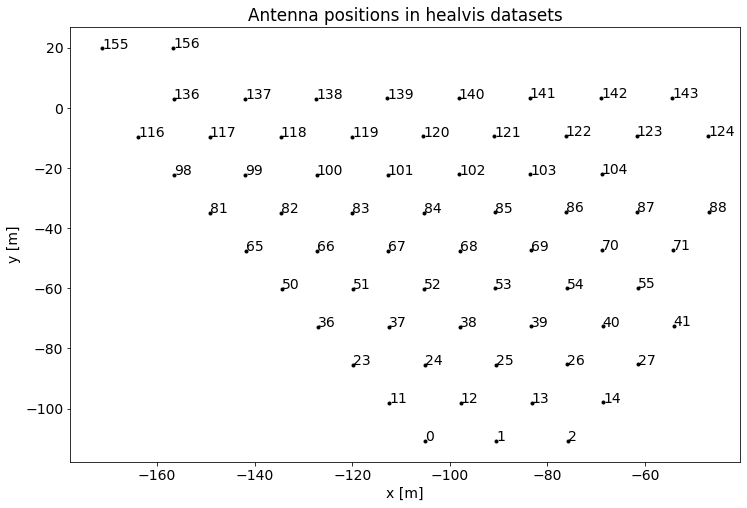

In [21]:
for key in gsm_hv.antpos.keys():
    antpos = gsm_hv.antpos[key]
    scatter(antpos[0], antpos[1], c='k', marker='.')
    annotate(key, (antpos[0], antpos[1]))
xlabel('x [m]')
ylabel('y [m]')
title(r'Antenna positions in healvis datasets');

## $\texttt{RIMEz}$ datasets

In [ ]:
rimez_dr = "/lustre/aoc/projects/hera/Validation/"

rimez_gsm_path = os.path.join(rimez_dr,
                              "hera_hex37_100-200MHz_HERA_dipole_eGSM_preview/hera_hex37_egsm_preview.uvh5")
uvd = UVData()
uvd.read(rimez_gsm_path, read_data=False)

In [96]:
rimez_lsts = np.unique(uvd.lst_array) * 12.0 / np.pi
rimez_lst_inds = np.where(np.logical_and(rimez_lsts >= start_lst, rimez_lsts <= end_lst))[0]
print('Rimez LST range: {}, {}'.format(rimez_lsts[rimez_lst_inds].min(), rimez_lsts[rimez_lst_inds].max()))

hv_freq_range = [gsm_hv.freq_array[0].min(), gsm_hv.freq_array[0].max()]
rimez_freq_inds = np.where(np.logical_and(uvd.freq_array[0] >= hv_freq_range[0],
                                          uvd.freq_array[0] <= hv_freq_range[1]))[0]

Rimez LST range: 0.00041993679453256044, 8.998930529362847
612


In [99]:
gsm_rimez = UVData()
gsm_rimez.read(rimez_gsm_path,
               bls=[(13, 6), (34, 21)],
               times=np.unique(uvd.time_array)[rimez_lst_inds],
               frequencies=uvd.freq_array[0][rimez_freq_inds],
               polarizations=['xx'])

Telescope RIMEz calculation is not in known_telescopes.


In [101]:
rimez_lsts = np.unique(gsm_rimez.lst_array) * 12.0 / np.pi

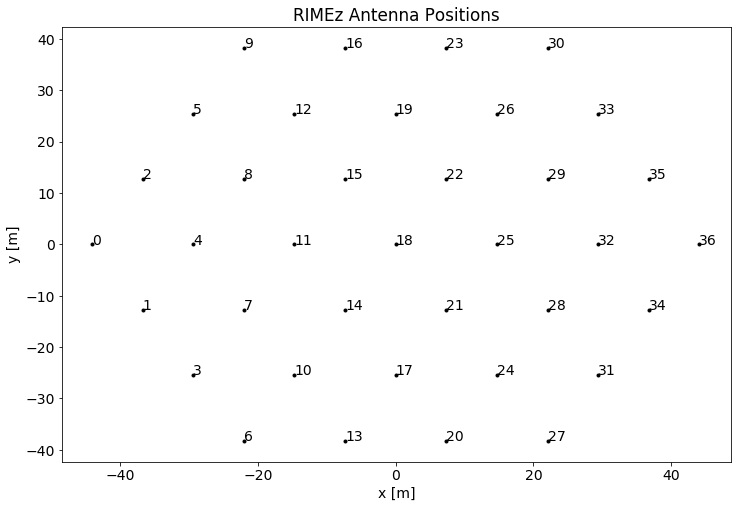

In [85]:
for antpos, antnum in zip(*(gsm_rimez.get_ENU_antpos())):
    scatter(antpos[0], antpos[1], c='k', marker='.')
    annotate(antnum, (antpos[0], antpos[1]))
xlabel('x [m]')
ylabel('y [m]')
title('RIMEz Antenna Positions');

# Compare 29 m EW baseline data

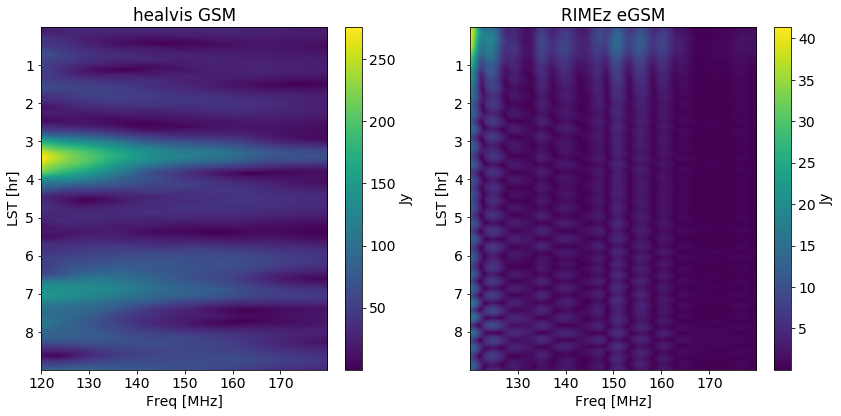

In [102]:
fig = figure(figsize=(12, 6))
nrows = 1
ncols = 2
gs = GridSpec(nrows, ncols)
axs = [fig.add_subplot(gs[i]) for i in range(nrows * ncols)]

hv_bl_key = (23, 25, 'xx')
hv_extent = [gsm_hv.freq_array[0].min() / 1e6, gsm_hv.freq_array[0].max() / 1e6,
             hv_lsts.max(), hv_lsts.min()]

rimez_bl_key = (34, 21, 'xx')
rimez_extent = [gsm_rimez.freq_array[0].min() / 1e6, gsm_rimez.freq_array[0].max() / 1e6,
                rimez_lsts.max(), rimez_lsts.min()]


ax = axs[0]
cax = ax.imshow(np.abs(gsm_hv.get_data(hv_bl_key)), extent=hv_extent, aspect='auto')
colorbar(cax, ax=ax, label='Jy')
ax.set_title('healvis GSM')

ax = axs[1]
cax = ax.imshow(np.abs(gsm_rimez.get_data(rimez_bl_key)), extent=rimez_extent, aspect='auto')
colorbar(cax, ax=ax, label='Jy')
ax.set_title('RIMEz eGSM')

for ax in axs:
    ax.set_xlabel('Freq [MHz]')
    ax.set_ylabel('LST [hr]')

gs.tight_layout(fig)

In [103]:
print(gsm_hv.freq_array[0].min(), gsm_hv.freq_array[0].max())
print(gsm_rimez.freq_array[0].min(), gsm_rimez.freq_array[0].max())

120000000.0 179765625.0
120039100.68426196 179765395.89442813


In [105]:
print(gsm_hv.lst_array.min(), gsm_hv.lst_array.max())
print(gsm_rimez.lst_array.min(), gsm_rimez.lst_array.max())

0.0006129264130095792 2.3542713660463432
0.00010993919572296153 2.355914503434269
